# Schwarzschild Orbit Simulation (Geodesics)

This notebook simulates test-particle orbits in Schwarzschild spacetime by numerically integrating the equations of motion in the equatorial plane $\left( \theta = \pi/2 \right).$

**Goal:** produce clear orbit plots (bound / unbound / plunge)

## Conventions & Units

We use **geometrized units** $\left( G = c = 1 \right).$ The parameter $(M)$ sets the length scale; the Schwarzschild radius is $\left( r_s = 2M \right).$

This notebook focuses on numerical integration + visualization.

## Setup & Effective Potential (core functions)


In [1]:
# Physical units: G = c = 1, M is the mass parameter of the central gravitating body.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


M = 1.0  # Schwarzschild-Mass, sets the lengthscale (Schwarzschildradius = 2M)



# effective potential and the derivative

def V_eff(r, L):
    """Effective Potential V_eff(r) for timelike geodesics.

    V_eff(r) = (1 - 2M/r) * (1 + L^2 / r^2)

    Inputs:
    - r : Radius (Scalar or numpy-Array)
    - L : Angular momentum per mass
    """
    return (1 - 2*M/r) * (1 + L**2 / r**2)


def dVdr(r, L):
    """Analytical derivative dV_eff/dr used in ODE for p_r.

    We use the easier form given as:
    dVdr = 2M/r^2 * (1 + L^2/r^2) - 2(1 - 2M/r) * (L^2/r^3)
    """
    return (2*M/r**2) * (1 + L**2/r**2) - 2*(1 - 2*M/r)*(L**2/r**3)

# Explanation:
# - V_eff gives us a visual intuition of the allowed regions for r.
# - Minima of V_eff correspond to stable circular orbits (if E^2 is equal to it) and maxima to unstable cicles.

## Effective potential visualization


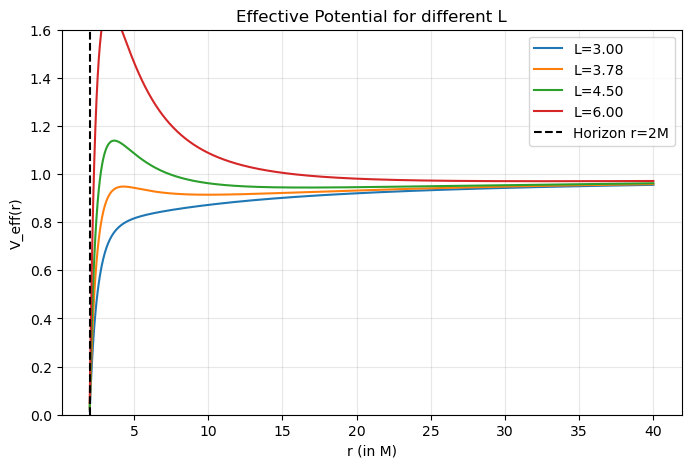

In [2]:
r_vals = np.linspace(2.01, 40, 1000)  # when r > 2M (Horizon at r=2M)

Ls = [3.0, 3.78, 4.5, 6.0]  # multiple values used for the angular momentum (examples)

plt.figure(figsize=(8,5))

for L in Ls:
    plt.plot(r_vals, V_eff(r_vals, L), label=f"L={L:.2f}")
    
plt.axvline(2*M, color='k', linestyle='--', label='Horizon r=2M')
plt.xlabel('r (in M)')
plt.ylabel('V_eff(r)')
plt.title('Effective Potential for different L')
plt.legend()
plt.ylim(0.0, 1.6)
plt.grid(alpha=0.3)
plt.show()

## ODE system (geodesic dynamics)


In [3]:
# Use r and p_r = dr/dτ as variables. This rewrites each second-order equation
# as a system of first-order equations:
#   dr/dτ = p_r
#   dp_r/dτ = -1/2 * dV_eff/dr
#   dφ/dτ = L / r^2
#
# Here, τ denotes the proper time parameter (for massive particles). These ODEs
# follow from differentiating the relation (dr/dτ)^2 = E^2 - V_eff(r).

# ODE-System definition

def geodesic_sys(tau, y, L):
    """System first order for solve_ivp.

    y = [r, p_r, phi]
    return: [dr/dtau, dp_r/dtau, dphi/dtau]
    """
    r, pr, phi = y

    #Protection: If r gets to small we encounter numerical problems, return zeros
    if r <= 0:
        # unphysical 
        return [0.0, 0.0, 0.0]

    dr_dtau = pr
    dpr_dtau = -0.5 * dVdr(r, L)
    dphi_dtau = L / r**2
    
    return [dr_dtau, dpr_dtau, dphi_dtau]


## Integrator wrapper (horizon stop event)


In [4]:
def integrate_orbit(r0, pr0, phi0, L, tau_max=200.0, max_step=0.5):
    """Integrates the ODE-System and returns the carteesian coordinates.
    
    Parameter:
    - r0, pr0, phi0 : Starting values
    - L : Angular momentum
    - tau_max : max. Integrationtime (proper time)
    - max_step : max. step size of the integrator
    
    returns: (x_array, y_array, r_array, phi_array, sol)
    sol is the complete solve_ivp object for future purpose.
    """
    
    y0 = [r0, pr0, phi0]

    def hit_horizon(tau, y, *args):
        # Event-Function: Zeropoint at r = 2M + eps
        return y[0] - (2*M + 1e-9)
    
    hit_horizon.terminal = True
    hit_horizon.direction = -1

    sol = solve_ivp(
        geodesic_sys,
        (0.0, tau_max),
        y0,
        args=(L,),
        max_step=max_step,
        rtol=1e-8,
        atol=1e-10,
        events=hit_horizon
    )

    r = sol.y[0]
    phi = sol.y[2]
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y, r, phi, sol

# Explanation of the returned values:
# - x, y: Cartesian coordinates of the orbit, used for plotting
# - r, phi: direct radial/azimuthal solutions, used for analysis
# - sol: full solution object (not strictly necessary, but useful for events / diagnostics)

## Plot helpers


## Orbit plotting (orbit + effective potential)


In [5]:
def plot_orbit_and_potential(x, y, r, L, E, title="Orbit + Potential"):
    """
    Left: Orbit (x,y) in the Schwarzschild regime.
    Right: Effective Potential V_eff(r) and Energy line E^2.
    
    
    Parameters:
    - x, y : Cartesian coordinates of the orbit (from integrate_orbit)
    - r    : radial trajectory r(tau) (from integrate_orbit)
    - L    : angular momentum per unit mass (same L as used in the ODE)
    - E    : energy per unit mass
    - title: title for the orbit plot
    """

    x = np.array(x)
    y = np.array(y)
    r = np.array(r)


    # Fixed global plot region for V_eff
    # 2.1M is slightly above the horizon, r_max can be choosen (no restriction)
    r_min_plot = 2.1 * M
    r_max_plot = 40.0 * M   # change if plot isn't helpful

    r_grid = np.linspace(r_min_plot, r_max_plot, 1000)
    V_grid = V_eff(r_grid, L)

    # r-Min and r-Max of the actual orbit:
    r_min_traj = np.min(r)
    r_max_traj = np.max(r)


    fig, (ax_orbit, ax_pot) = plt.subplots(1, 2, figsize=(12, 5))

    # --- left: Orbit ---
    ax_orbit.plot(x, y, '-', lw=1)
    ax_orbit.plot(0, 0, 'ko', markersize=6)  # Center
    circle = plt.Circle((0, 0), 2*M, fill=False, linestyle='--', color='k')
    ax_orbit.add_artist(circle)

    ax_orbit.set_aspect('equal', 'box')
    ax_orbit.set_xlabel('x (in M)')
    ax_orbit.set_ylabel('y (in M)')
    ax_orbit.set_title(title)
    ax_orbit.grid(alpha=0.3)

    # --- right: effective Potential ---
    ax_pot.plot(r_grid, V_grid, label=r'$V_\mathrm{eff}(r)$')
    ax_pot.axhline(E**2, color='r', linestyle='--', label=r'$E^2$')

    # Lightly shade the region where motion is allowed (E^2 >= V_eff)
    allowed = E**2 >= V_grid
    ax_pot.fill_between(r_grid, V_grid, E**2, where=allowed, color='orange', alpha=0.25)

    # Horizon mark up
    ax_pot.axvline(2*M, color='k', linestyle=':', label='Horizon r=2M')

    # Highlight the radial range of the trajectory
    ax_pot.axvspan(r_min_traj, r_max_traj, color='gray', alpha=0.15,
                   label='r-region of the orbit')

    ax_pot.set_xlabel('r (in M)')
    ax_pot.set_ylabel(r'$V_\mathrm{eff}(r)$')
    ax_pot.set_title('Effective Potential')
    ax_pot.legend(fontsize=8)
    ax_pot.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    
'''' 
def plot_orbit(x, y, title="Orbit", show_horizon=True):
    plt.figure(figsize=(6,6))
    plt.plot(x, y, '-', lw=1)
    plt.plot(0, 0, 'ko', markersize=6)
    if show_horizon:
        circle = plt.Circle((0,0), 2*M, color='k', fill=False, linestyle='--')
        plt.gca().add_artist(circle)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel('x (in M)')
    plt.ylabel('y (in M)')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()
'''

'\' \ndef plot_orbit(x, y, title="Orbit", show_horizon=True):\n    plt.figure(figsize=(6,6))\n    plt.plot(x, y, \'-\', lw=1)\n    plt.plot(0, 0, \'ko\', markersize=6)\n    if show_horizon:\n        circle = plt.Circle((0,0), 2*M, color=\'k\', fill=False, linestyle=\'--\')\n        plt.gca().add_artist(circle)\n    plt.gca().set_aspect(\'equal\', \'box\')\n    plt.xlabel(\'x (in M)\')\n    plt.ylabel(\'y (in M)\')\n    plt.title(title)\n    plt.grid(alpha=0.3)\n    plt.show()\n'

## Initial condition consistency check


In [6]:
def check_initial_conditions(r0, L, E, verbose=True):
    """Checks if E^2 >= V_eff(r0) (if not, p_r is imaginary).

    returns p_r0 (pos. Square root)."""
    V0 = V_eff(r0, L)
    if E**2 < V0 - 1e-12:
        if verbose:
            print(f"Inconsistent starting parameters: E^2={E**2:.6f} < V_eff(r0)={V0:.6f}")
        return None
    pr0 = np.sqrt(max(E**2 - V0, 0.0))
    if verbose:
        print(f"Starting value OK: r0={r0}, L={L:.3f}, E={E:.6f}, p_r0={pr0:.6f}")
    return pr0


## Examples / demo runs


=== Example 1: Stable Circular Orbit ===
r0=15.0, L=4.330127, E=0.968963, p_r0=0.0


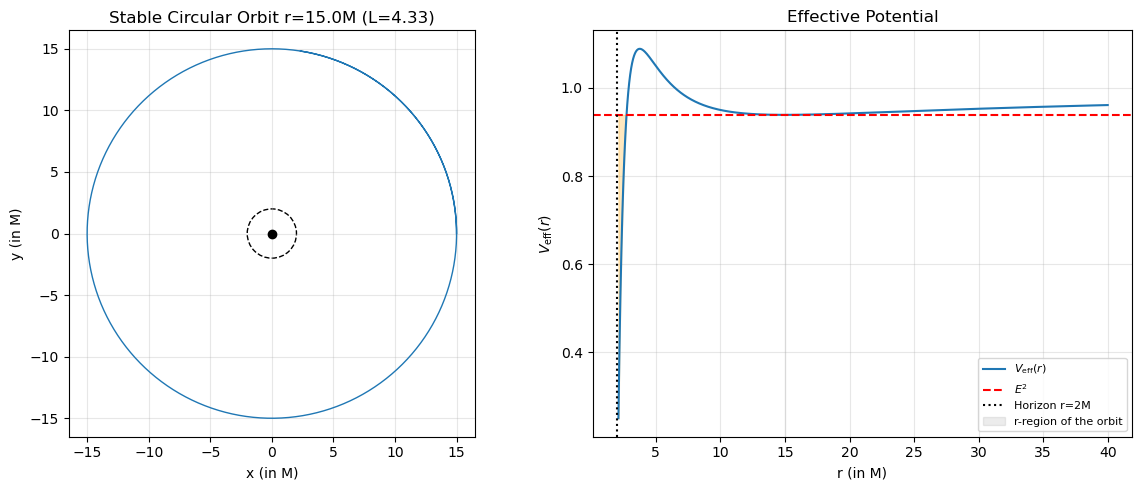

=== Example 2: Bound Orbit (elliptical) ===
Starting value OK: r0=12.0, L=4.330, E=0.977000, p_r0=0.112672


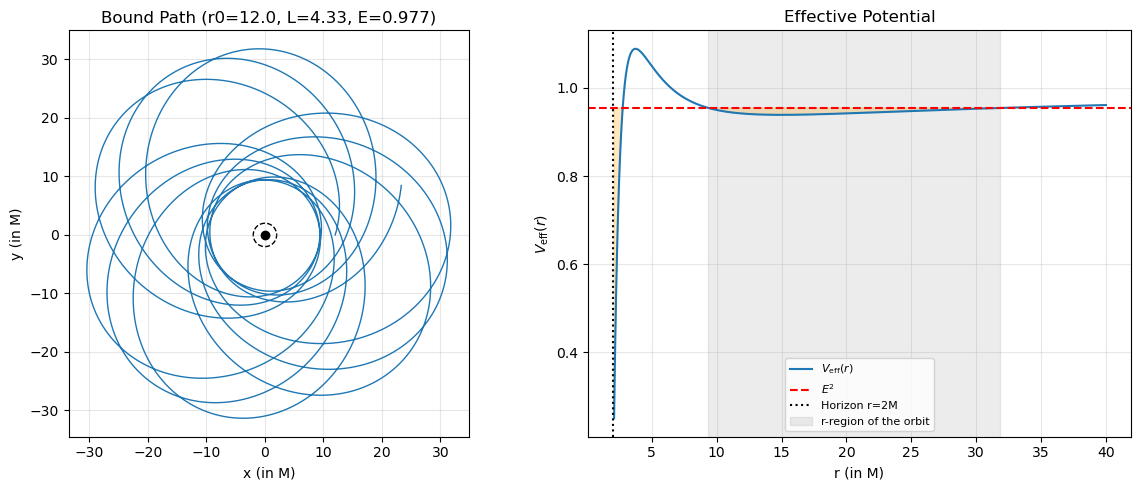

=== Example 3: Unbound Path (E>1) ===
Starting value OK: r0=30.0, L=4.330, E=1.005000, p_r0=0.239266


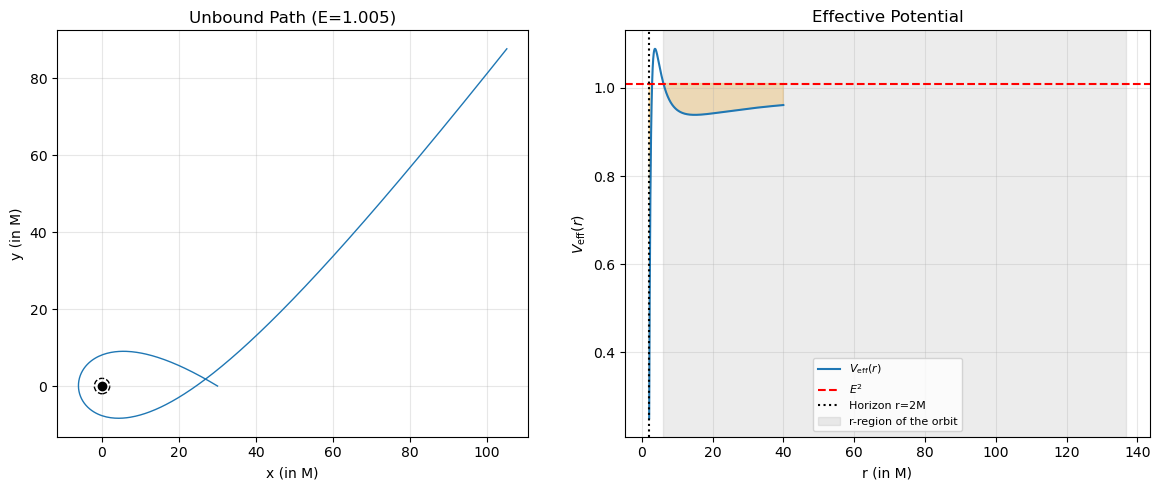

=== Example 4: Plunge (Collapse into the black hole) ===
Example: r0=8.0, L=4.33, E=1.06, p_r0=-0.392283


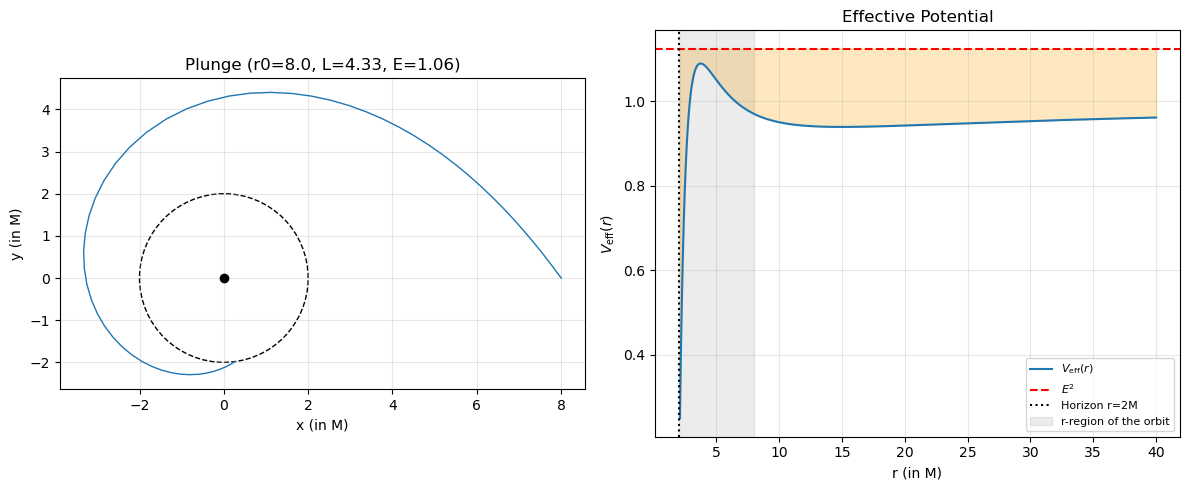

In [7]:
# Multiple different examples

# 1) Stable Circular Orbit
r0 = 15.0
L_circ = np.sqrt(M * r0 / (1 - 3*M/r0))  # analytical Formula for L of a circ. orbit
E_circ = np.sqrt((1 - 2*M/r0) * (1 + L_circ**2 / r0**2))  # energy
pr0 = 0.0  # for perfect circle we need dr/dtau = 0
print('=== Example 1: Stable Circular Orbit ===')
print(f'r0={r0}, L={L_circ:.6f}, E={E_circ:.6f}, p_r0={pr0}')
x,y,r,phi,sol = integrate_orbit(r0, pr0, 0.0, L_circ, tau_max= 400.0, max_step=0.5)
plot_orbit_and_potential(x, y, r, L=L_circ, E=E_circ, title=f"Stable Circular Orbit r={r0}M (L={L_circ:.2f})")

#plot_orbit(x, y, title=f"Stable Circular Orbit r={r0}M (L={L_circ:.3f})")



# 2) Bound Orbit (elliptical) – Choose E such that E^2 lies between min and 1.
# Here we choose r0 slightly bigger and set pr0 > 0 (motion outwards at the start)
r0 = 12.0
L = 4.33
E = 0.977
print('=== Example 2: Bound Orbit (elliptical) ===')
pr0 = check_initial_conditions(r0, L, E)
if pr0 is not None:
    x,y,r,phi,sol = integrate_orbit(r0, pr0, 0.0, L, tau_max=6000.0, max_step=0.5)
    plot_orbit_and_potential(x, y, r, L, E, title=f"Bound Path (r0={r0}, L={L}, E={E})")

    
    
# 3) Unbound Orbit (E > 1) – Hpyerbolic flight trajectory
r0 = 30.0
L = 4.33
E = 1.005
print('=== Example 3: Unbound Path (E>1) ===')
pr0 = check_initial_conditions(r0, L, E)
if pr0 is not None:
    x,y,r,phi,sol = integrate_orbit(r0, -pr0, 0.0, L, tau_max=800.0, max_step=1.0)
    plot_orbit_and_potential(x, y, r, L, E, title=f"Unbound Path (E={E})")

    
    
# 4) Plunge (Einfall) – Starting conditions such that we "fall" into the hole. (Event stops at r=2M)
r0 = 8.0
L = 4.33
E = 1.06
print('=== Example 4: Plunge (Collapse into the black hole) ===')
pr0 = -np.sqrt(max(E**2 - V_eff(r0, L), 0.0))
print(f'Example: r0={r0}, L={L}, E={E}, p_r0={pr0:.6f}')
x,y,r,phi,sol = integrate_orbit(r0, pr0, 0.0, L, tau_max=400.0, max_step=0.5)
plot_orbit_and_potential(x, y, r, L, E, title=f"Plunge (r0={r0}, L={L}, E={E})")

## Additional analyses


In [8]:
# Few known Radii:
r_photon = 3*M   # Photon sphere (for light)
r_isco = 6*M     # Innermost stable circular orbit (ISCO)
print('Important radii:')
print(f'Photon sphere r = 3M -> {r_photon}')
print(f'Innermost stable circular orbit (ISCO) r = 6M -> {r_isco}')

Important radii:
Photon sphere r = 3M -> 3.0
Innermost stable circular orbit (ISCO) r = 6M -> 6.0


## Animation

This section creates a **GIF animation** from an already integrated orbit.

1. Run one of the example integrations that produces arrays `x, y` (Cartesian orbit coordinates).
2. Run the cell below to save `figures/orbit.gif`.

In [9]:
from matplotlib.animation import FuncAnimation
import os

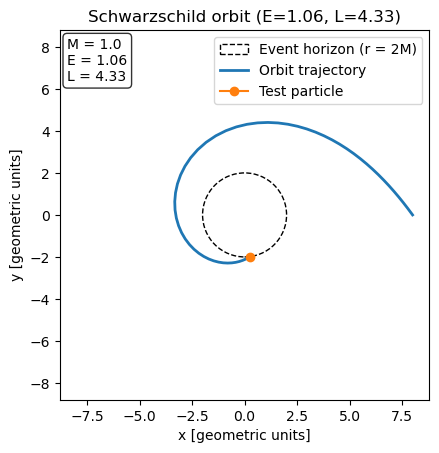

Saved animation to: figures/orbit.gif


In [10]:
# Make sure you have x, y from a previous integration.
assert 'x' in globals() and 'y' in globals(), "Run an orbit integration first so that x,y exist."

# Ensure output folder exists
os.makedirs("figures", exist_ok=True)

fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

R = np.max(np.sqrt(x**2 + y**2))
pad = 1.1
ax.set_xlim(-pad * R, pad * R)
ax.set_ylim(-pad * R, pad * R)

# Labels & Title
ax.set_xlabel("x [geometric units]")
ax.set_ylabel("y [geometric units]")
ax.set_title(f"Schwarzschild orbit (E={E}, L={L})")

# Event horizon (r = 2M)
horizon = plt.Circle((0, 0), 2*M, fill=False, linestyle="--", label="Event horizon (r = 2M)")
ax.add_patch(horizon)

param_text = (f"M = {M}\n"
    f"E = {E}\n"
    f"L = {L}")

ax.text(0.02, 0.98, param_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Animations
trail, = ax.plot([], [], lw=2, label = "Orbit trajectory")
point, = ax.plot([], [], marker="o", label = "Test particle")

ax.legend(loc="upper right")

# Downsample for smoother / lighter animations
step = max(len(x) // 800, 1)
xA, yA = x[::step], y[::step]

def init():
    trail.set_data([], [])
    point.set_data([], [])
    return trail, point

def update(i):
    trail.set_data(xA[:i+1], yA[:i+1])
    point.set_data([xA[i]], [yA[i]])
    return trail, point


ani = FuncAnimation(fig, update, frames=len(xA), init_func=init, blit=True, interval=20)

out_path = "figures/orbit.gif"
ani.save(out_path, writer="pillow", fps=30)

plt.show()
print(f"Saved animation to: {out_path}")